## This notebook will discuss two concepts, 
### 1. Training curve
> Plot of how the training of a model proceeds with increasing data size or class instances
### 2. Scoring algorithms
> 'Accuracy' scoring is not the only scoring parameter availabel. 

# Training curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

df_AIMD = pd.read_csv("Dist_AIMD.csv") 
df_MD = pd.read_csv('Dist_MD.csv')
df_fin = pd.concat([df_AIMD, df_MD])

df_shuffle = shuffle(df_fin, random_state=0)

# Calculate correlation between all features
corr = df_shuffle.iloc[:,2:].corr()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop the features 
df_drop = df_shuffle.drop(columns=to_drop)

# Separate features and targets
X = df_drop.iloc[:,2:]
y = df_drop['Class']

# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=0)

print("Shape of the training data: ", X_train.shape)

Shape of the training data:  (400, 9)


stratify: train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset. 

Our data is already balanced, so there was no need for it but for unbalanced data, stratify is useful.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# best n_neighbors was 12 for O dataset and 8 for H
knn = KNeighborsClassifier(n_neighbors=10) 

# C = 100 was stable for both sets
lr = LogisticRegression(C=100, random_state=0)

# 3 different kernels had different performances, let's fix gamma ~ 1/6
svc_lin = SVC(kernel='linear', C=1.0, random_state=0)
svc_poly = SVC(kernel='poly', degree=3, C=1.0, gamma=0.17, random_state=0)
svc_rbf = SVC(kernel='rbf', C=1.0, gamma=0.17, random_state=0)

# DecisionTrees are special since correlated features don't matter to them
dt = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf=10)

# For NaiveBayes they matter a lot 
nb = GaussianNB()

# RandomForest and GBC showed signs of overfitting but had high test scores too 
rf = RandomForestClassifier(random_state=0, max_depth=4, max_features='auto', n_estimators=10)
gbc = GradientBoostingClassifier(random_state=0, learning_rate=0.25, max_depth=3, min_samples_split=8, n_estimators=25)

# MLP showed issues with learning 
mlp = MLPClassifier(solver='lbfgs', activation='logistic', alpha = 0.0005, random_state=0, 
                        hidden_layer_sizes=[50,50], max_iter=300)

#Dict with modes names and models
models = {'knn' : knn, 
          'lr' : lr, 
          'svc_lin' : svc_lin, 
          'svc_poly' : svc_poly, 
          'svc_rbf' : svc_rbf, 
          'dt' : dt, 
          'nb' : nb, 
          'rf' : rf, 
          'gbc' : gbc, 
          'mlp' : mlp}


In [3]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X_train, y_train, train_sizes, ax, model_name):
    
    #Calculate the train sizes, scores and test scores using the learning_curve function
    train_sizes, train_scores, test_scores = learning_curve(est, X_train, y_train,
                                             cv=10, train_sizes=train_sizes)
    
    # Calculate training and test mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    ax.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    ax.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    ax.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation')
    ax.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    
    ax.set_title('Learning Curve for {}'.format(model_name), fontsize=15)
    ax.legend(loc='lower right', fontsize=15)


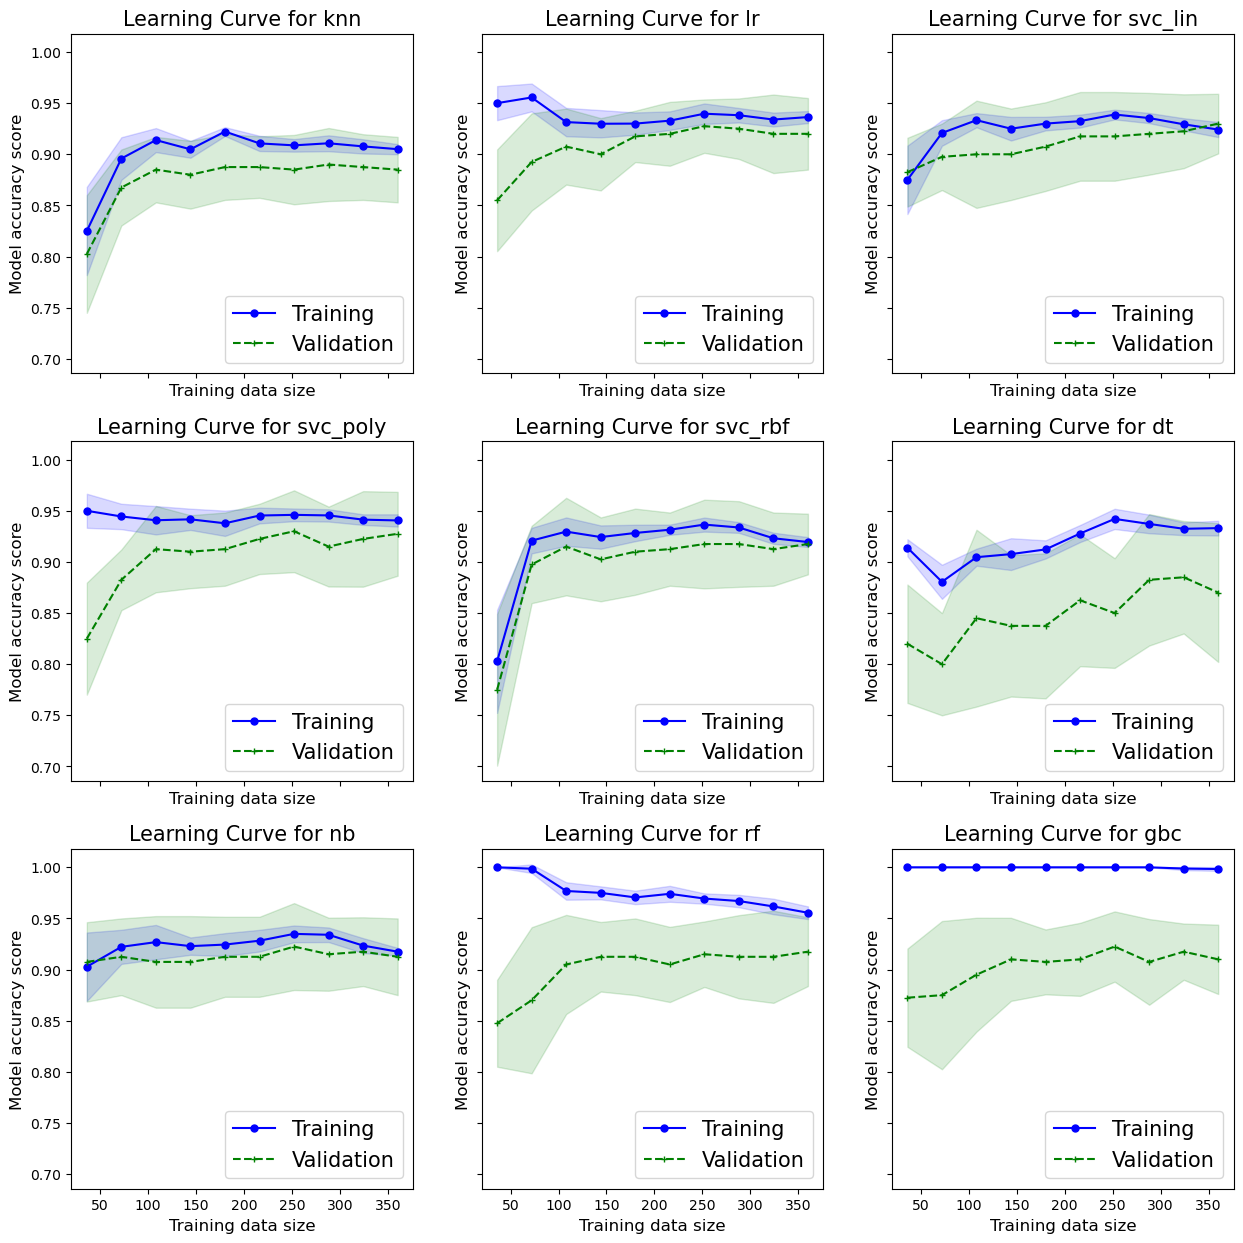

In [4]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,15))
axs = ax.flatten()

for ax_l, model_name in zip(axs, models.keys()):
        ax_l.set_xlabel("Training data size", fontsize=12)
        ax_l.set_ylabel("Model accuracy score", fontsize=12)
        train_sizes = np.linspace(0.1, 1.0, 10)
        plot_learning_curve(models[model_name], X_train, y_train, train_sizes, ax_l, model_name)


### The plots above show the training and validation accuracy of different models with increasing training data. There are roughtly 3 types of plots observed, 
1. Training and validation accuracy starts low when using less data to train and both increase to a plateau as we increase the training data size. E.g. kn, scv_rbf

2. Training score starts very high (indicating overfitting) and validation score starts low and converge as the training data increases. The decreasing training score means the model is geenralizing better which is indicated by increasing validation score. E.g. lr(logistic regression), svc_ploy, mlp, rf 

3. Both training and validation score start high and don't change much with increasing training data size. E.g. svc_lin, nb(naive bayes)

### It is also interesting to see what is happening with DecisionTree and EnsembleDT models, 
1. DecsionTree(dt): Clearly overfit and is staying overfit regardless of training data size. This is indicated by very high training accuracy and poor validation accuracy. 

2. RandomForest(rf): Better than DecisionTree but still overfit. However, with increasing data size the training accuracy is decreasing slowly validation accuracy is increasing and it looks like with more data, they will converge. 

3. GradientBoosingDT(gbc): Extremely overfit and shows no signs of improving with increasing training size.

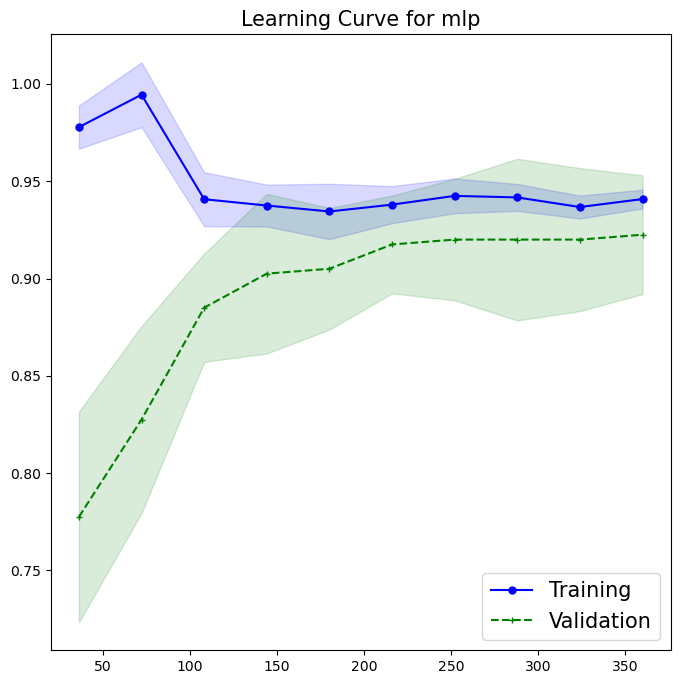

In [5]:
# For the NN 
fig, ax = plt.subplots(1,1, figsize=(8,8))

plot_learning_curve(models['mlp'], X_train, y_train, train_sizes, ax, 'mlp')

# Scoring: Moving beyond accuracy

In our model we have been accuracy as our scorer, which is suitable for us. However, different tasks have different scoring requirements. For example, a classifier dealing with cancer detection has different requirements from our classification task. 

In binary classification (say between positive and negative classes), there are 4 outcomes possible :
1. True positive(TP): Positive class correctly identified as such
2. True negative(TN): Negative class correctly identified as such
3. False positive(FP): Negative class incorrectly identified as positive
4. False negative(FN): Positive class incorrectly identified as negative

In our example above about cancer detection, the model must have a very high true positive (TP) AND low false negative (FN), which is quantified by 'recall' scoring. 

### Some examples of scoring parameters for classification with definitions,
1. 'accuracy' : Fraction of correct predictions 
> $\frac{TP + TN}{TP + TN + FP + FN}$
2. 'recall' : Fraction of all positive instances that the model correctly predict as positive.
> $\frac{TP}{TP + FN}$
3. 'precision' : Fraction of positive predictions that are correct
> $\frac{TP}{TP + FP}$
4. 'f1_score' : Usually interpreted as the harmonic mean of precision and reccall parameters
> $2 * \frac{Precision * Recall}{Precision + Recall}$ 

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

#Train a model
nb = GaussianNB().fit(X_train, y_train)

#Collect predictions
y_pred = nb.predict(X_test)

#Print scores
print("Default score of the model: ", nb.score(X_test, y_test))
print("Accuracy score of the model: ", accuracy_score(y_test, y_pred))
print("Recall score of the model: ", recall_score(y_test, y_pred))
print("Precision score of the model: ", precision_score(y_test, y_pred))
print("f1 score of the model: ", f1_score(y_test, y_pred))

print("\nClassification report of the model\n", classification_report(y_test, y_pred, target_names=['MD', 'AIMD']))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Default score of the model:  0.9166666666666666
Accuracy score of the model:  0.9166666666666666
Recall score of the model:  0.8809523809523809
Precision score of the model:  0.9487179487179487
f1 score of the model:  0.9135802469135802

Classification report of the model
               precision    recall  f1-score   support

          MD       0.89      0.95      0.92        42
        AIMD       0.95      0.88      0.91        42

    accuracy                           0.92        84
   macro avg       0.92      0.92      0.92        84
weighted avg       0.92      0.92      0.92        84


Confusion matrix:
 [[40  2]
 [ 5 37]]


Let's go through the above step by step,
1. The score method returns accuracy score by default, the cross_val_score function has a scoring parameter which will return the scoring parameter we input. For more scoring parameters check scikit-learn [scorers page](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

2. The GaussianNB precision score is higher than recall (which means we might call it a precision oriented model, but it depends on the task). 

3. The classification report prints out a detailed scoring result which includes parameters which we have not defined here. Still, it gives important information about the model. 

4. The confusion matrix is a matrix made up of predictions arranged as true label vs predicted label. So, the diagonals indicate the TP and TN scores while the off diagonals are the FN and FP scores.

## Decision function

Prediction confidence score for a sample. Each score value indicates how confidently the classifier predicts the "positive class" (the one with positive scores) or the "negative class" (the one with negative scores). 
NOTE: Not all classifiers have this method

In [7]:
# make a list of score lists
y_score_lr = LogisticRegression(C=100).fit(X_train, y_train).decision_function(X_test)

y_score_list = list(zip(y_test[0:20], y_score_lr[0:20]))
y_score_list

[(1, 5.9199382549422666),
 (1, 4.4753228979044195),
 (0, -5.051739347282464),
 (0, -6.8851755201283),
 (0, -4.561970557950389),
 (1, 2.7076245150591376),
 (1, -3.48714049690453),
 (0, -3.622175134433107),
 (0, -2.7362042912061213),
 (1, 2.2476775240566553),
 (1, 3.0353032101940585),
 (1, -0.19182485645490033),
 (1, 3.687509704611344),
 (0, -6.0922741240792675),
 (0, -7.847027014340284),
 (1, 7.3341040840059435),
 (1, 0.7793028194608524),
 (1, 4.340026275370448),
 (1, 2.076326641138806),
 (1, 5.691100585772702)]

We can see that the class 1 is assigned positive values and 0 is assigned negative values, but we also see wrong predictions where class 1 is assigned a negative value (and is predicted as class 0).

### Similarly, we can print the list of predicted probability of class membership

In [8]:
y_proba_lr = LogisticRegression(C=100).fit(X_train, y_train).predict_proba(X_test)

y_proba_list = list(zip(y_test[0:20], y_proba_lr[0:20]))
y_proba_list

[(1, array([0.00267817, 0.99732183])),
 (1, array([0.01125835, 0.98874165])),
 (0, array([0.99364248, 0.00635752])),
 (0, array([0.99897821, 0.00102179])),
 (0, array([0.98966643, 0.01033357])),
 (1, array([0.06252495, 0.93747505])),
 (1, array([0.97031965, 0.02968035])),
 (0, array([0.97397112, 0.02602888])),
 (0, array([0.93912948, 0.06087052])),
 (1, array([0.09554999, 0.90445001])),
 (1, array([0.04585623, 0.95414377])),
 (1, array([0.5478097, 0.4521903])),
 (1, array([0.02442286, 0.97557714])),
 (0, array([0.99774483, 0.00225517])),
 (0, array([9.99609240e-01, 3.90759667e-04])),
 (1, array([6.52462586e-04, 9.99347537e-01])),
 (1, array([0.31447016, 0.68552984])),
 (1, array([0.01286843, 0.98713157])),
 (1, array([0.11141913, 0.88858087])),
 (1, array([0.00336452, 0.99663548]))]

The second element of each set is the probability that the member belongs to class 0 ('MD') or 1 ('AIMD') in our case.

## [Precision Recall Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn-metrics-precision-recall-curve)
Plots the precision and recall values for different thresholds. It is restricted to binary classification task and this curve is important to see the effects of varying thresholds on the scoring parameters. 

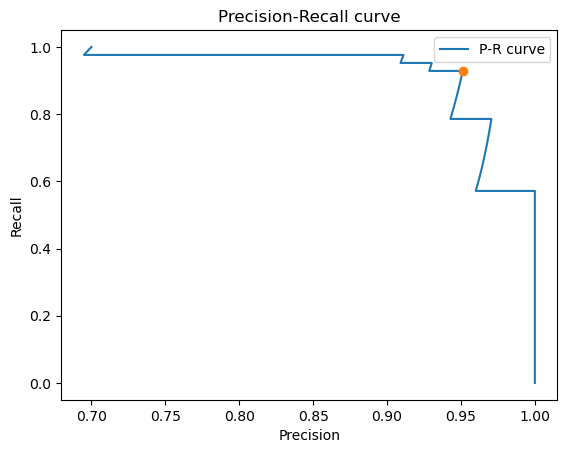

In [9]:
from sklearn.metrics import precision_recall_curve

prec, recall, thresholds = precision_recall_curve(y_test, y_score_lr)

closest_zero = np.argmin(np.abs(thresholds)) # Determine the threshold value closest to 0
closest_zero_p = prec[closest_zero] # Precision value at threshold ~ 0
closest_zero_r = recall[closest_zero] # Recall value at threhold ~ 0

fig = plt.figure()

plt.plot(prec, recall, label='P-R curve')
plt.plot(closest_zero_p, closest_zero_r, 'o')

plt.title("Precision-Recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc='best')

plt.show()

There are other plots like ROC ([Receiver Operating Characteristic](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)) curves but we will not be discussing them here.